# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False, ngram_range=(1,2),analyzer='word',stop_words='english')
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/moviereviews_train.tsv', my_random_seed=50)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/Users/skyladfah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


{'Pos': 10022, 'Neg': 9978, 'TP': 4882, 'TN': 5110, 'FP': 4868, 'FN': 5140, 'Accuracy': 0.4996, 'Precision': 0.5007179487179487, 'Recall': 0.4871283177010577, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm5 = linear_model.SGDClassifier(alpha=100.0)
svm5.fit(X_train, y_train)

svm5_performance_train = BinaryClassificationPerformance(svm5.predict(X_train), y_train, 'alpha_100.0')
svm5_performance_train.compute_measures()
print(svm5_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10017, 'TN': 9977, 'FP': 1, 'FN': 5, 'Accuracy': 0.9997, 'Precision': 0.9999001796765822, 'Recall': 0.9995010975853124, 'desc': 'alpha_100.0'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'original')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'original'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 8777, 'TN': 5854, 'FP': 4124, 'FN': 1245, 'Accuracy': 0.73155, 'Precision': 0.6803348577629641, 'Recall': 0.8757732987427659, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

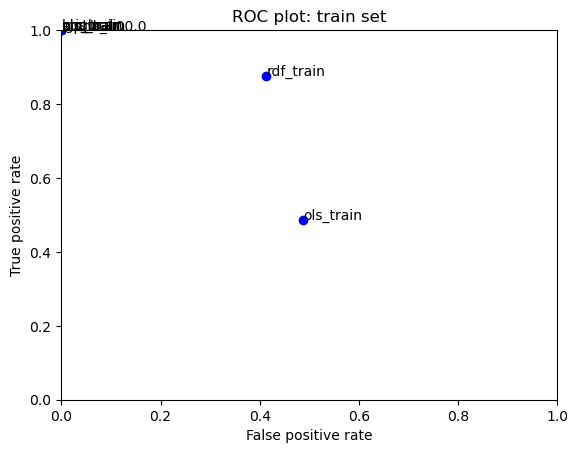

In [12]:
fits = [ols_performance_train, svm5_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
0
One of the those \coming of age\" films that should have nostalgia for adults and promise for the kids. This movie has neither. It is a poor excuse to let Sylvia Kristel's body double frolic with a dorky Eric Brown. To make matters worse, the movie is either silly or stupid when it tries to be funny, sexy, or dramatic. Laugh awkwardly as we are supposed to believe that a teenager would go alone with burying a dead woman in his front yard. Ponder vigorously on why a woman famous for Emmanuelle needs a body double. As the movie went on and on, I started to imagine a hybrid of Private Lessons and Little Miss Millions that had Sylvia Kristel seduce Jennifer Love Hewitt as Howard Hesseman makes us nostalgic for WKRP. Watch this to laugh at other people's stupidity, or for Ed Begley Jr.'s committed performance, or to wonder what Sylvia Kristel would look like with Jennifer Love Hewitt. But I can give you an idea of your lesson, stay away from movies staring Syl

4165
Really an amazing pile of pap! <br /><br />A predictable, slow moving, soul destroying, mind numbing movie to which, slitting your own wrists with a rusty bread knife seems... well, almost necessary.<br /><br />The acting is over done for the thin dialogue, every scene is at least twice as long as it needs to be, the intricate details of how this career is collapsing or that career is rising is just far too dreary and mundane for words. The music would be good if you didn't have to sit through the movie, but really, three good songs is not enough reward for the effort required to watch the movie.<br /><br />Watching this film I prayed to God for narcolepsy or for someone to shoot me.<br /><br />Never, ever, ever again.
* * * * * * * * * 
4297
I will warn you here: I chose to believe those reviewers who said that this wasn't an action film in the usual sense, rather a psychological drama so you should appreciate it on that basis and you will be alright.<br /><br />I am here to tell

9244
This movie is not just bad, not just corny, it is repulsive. Something about Daphne, about the creepy call-girl, about the whole damn (and I use the word literally) film radiates a grotesquery that would offend a brothel mistress. This film makes my skin crawl, makes me regret having reproductive organs, and makes me feel unclean.<br /><br />One of the things that bothers me most about this movie is that they used such a good concept. A creature that makes fantasies with disastrous results, rather than the cliché Worst Nightmare and the overdone Twisted Wish, is a truly fascinating film idea.<br /><br />Thought: The reason why hobgoblins need to be killed before day is that they are attracted to bright lights. During the day, bright lights don't show up well, so they could go anywhere.<br /><br />Count the Hobgoblins: Four hobgoblins drive out of the film studio, and yet at least nine of the pernicious plush-toys are killed throughout the course of the movie.<br /><br />Discussion

13661
The first Cube movie was an art movie. It set up a world in which all the major archetypes of mankind were represented, and showed how they struggled to make sense of a hostile world that they couldn't understand. It was, on the non-literal level, a \man vs. cruel nature\" plot, where the individual who represented innocence and goodness came through in the end, triumphing to face a new, indefinable world beyond man's petty squabbles; a world where there were no more struggle, but peace. I rated Cube a 10 out of 10, and it's a movie that was never meant to have any sequels.<br /><br />The second movie, Hypercube was a massive disappointment. Some of the ideas were kind of cool, but in the context of the original movie, both the story and the setting made no sense and had no meaning. Still, for being fairly entertaining, I rated it a 5 out of 10.<br /><br />The third movie, Cube Zero, while ignoring the second, plays like a vastly inferior commercial B-movie rehash of the first, s

18651
The plot of The Thinner is decidedly thin. And gross. An obese lawyer drives over the Gypsy woman, and the Gypsy curse causes him to lose and lose weight... to the bone. OK, Gypsy curses should be entertaining, but the weight-losing gone bad? Nope. Except Stephen King thinks so. And Michael McDowell, other horror author and the screenwriter of this abysmal film, does so, too. The lawyer is not only criminally irresponsible, he is fat too, haha! The Thinner is like an immature piece of crap for a person who moans how he/she has never seen anything so disgusting than fatness. Hey, I can only say: Well, look at the mirror.
* * * * * * * * * 
18785
*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** <br /><br />Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on late at night, read a book instead. I am currently in the process of recovering from a seizure, due to reading some of the comments on this film

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1218, 'TN': 1322, 'FP': 1200, 'FN': 1260, 'Accuracy': 0.508, 'Precision': 0.5037220843672456, 'Recall': 0.4915254237288136, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm5_performance_test = BinaryClassificationPerformance(svm5.predict(X_test), y_test, 'svm_test')
svm5_performance_test.compute_measures()
print(svm5_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2096, 'TN': 2169, 'FP': 353, 'FN': 382, 'Accuracy': 0.853, 'Precision': 0.8558595345038791, 'Recall': 0.8458434221146085, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1971, 'TN': 1968, 'FP': 554, 'FN': 507, 'Accuracy': 0.7878, 'Precision': 0.7805940594059406, 'Recall': 0.7953995157384988, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1829, 'TN': 1644, 'FP': 878, 'FN': 649, 'Accuracy': 0.6946, 'Precision': 0.675655707425194, 'Recall': 0.7380952380952381, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1943, 'TN': 1949, 'FP': 573, 'FN': 535, 'Accuracy': 0.7784, 'Precision': 0.7722575516693164, 'Recall': 0.7841000807102502, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2196, 'TN': 2099, 'FP': 423, 'FN': 282, 'Accuracy': 0.859, 'Precision': 0.8384879725085911, 'Recall': 0.8861985472154964, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2127, 'TN': 1409, 'FP': 1113, 'FN': 351, 'Accuracy': 0.7072, 'Precision': 0.6564814814814814, 'Recall': 0.8583535108958837, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

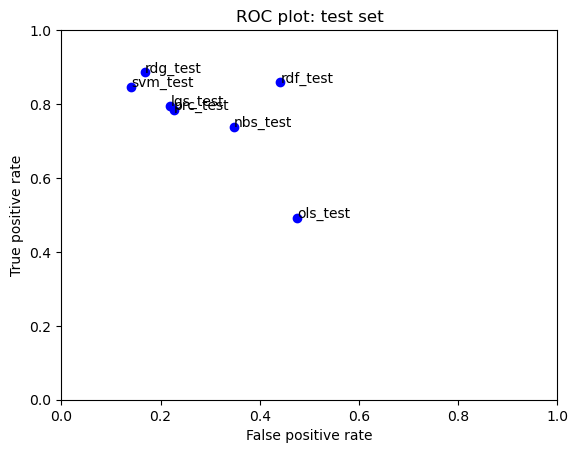

In [22]:
fits = [ols_performance_test, svm5_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/moviereviews_test.tsv', my_random_seed=50, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Siz

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm5.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49584


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,1


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/skyladfah/Documents/MachineLearning/ml_22/moviereviews_final_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation